In [213]:
!pip3 install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
import sys
sys.path.append('src/')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import ast
import matplotlib.pyplot as plt

# panda view settings
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', 500)  # Display full text in columns

In [2]:
DEVICE = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)

cpu


## Read from exisiting csvs

In [215]:
df = pd.read_csv("./data/toxicbias_train.csv")
df_bias = df[df['bias'] == 'bias']
df_neutral = df[df['bias'] == 'neutral']


In [3]:
# Read the CSV files into DataFrames
df_political_results = pd.read_csv('./results/final/political_results.csv')
df_gender_results = pd.read_csv('./results/final/gender_results.csv')
df_lgbtq_results = pd.read_csv('./results/final/lgbtq_results.csv')
df_race_results = pd.read_csv('./results/final/race_results.csv')
df_religion_results = pd.read_csv('./results/final/religion_results.csv')

# read training results 
df_political_training = pd.read_csv('./results/training/training_political_results.csv')
df_gender_training = pd.read_csv('./results/training/training_gender_results.csv')
df_lgbtq_training = pd.read_csv('./results/training/training_lgbtq_results.csv')
df_race_training = pd.read_csv('./results/training/training_race_results.csv')
df_religion_training = pd.read_csv('./results/training/training_religion_results.csv')

# Combine the DataFrames into one
combined_df = pd.concat([df_political_results, df_gender_results, df_lgbtq_results, df_race_results, df_religion_results], ignore_index=True)
combined_training_df = pd.concat([df_political_training, df_gender_training, df_lgbtq_training, df_race_training, df_religion_training], ignore_index=True)

## Split up dataframe by category

In [216]:
# store unique categories
unique_categories = set()

# Iterate through each entry in the 'category' column
for categories in df['category'].str.split(','):
    for category in categories:
        stripped_category = category.strip()
        if stripped_category and stripped_category.lower() != 'none':
            unique_categories.add(stripped_category)

unique_categories_list = sorted(list(unique_categories))

In [217]:
categorical_dfs = {category: pd.DataFrame(columns=df.columns) for category in unique_categories_list}

# Split categories and add rows to the corresponding dataframes in dictionary
def split_categories_and_add_rows(row):
    categories = row['category'].split(',')
    for category in categories:
        category = category.strip()  # Remove leading/trailing spaces
        if category in categorical_dfs:
            categorical_dfs[category] = categorical_dfs[category].append(row, ignore_index=True)

df_bias.apply(split_categories_and_add_rows, axis=1)

# Print the shape of each category dataframe
for category, category_df in categorical_dfs.items():
    print(f"Dataframe for {category}:")
    print(f"Shape: {category_df.shape}")
    print("\n")

Dataframe for gender:
Shape: (293, 6)


Dataframe for lgbtq:
Shape: (453, 6)


Dataframe for political:
Shape: (172, 6)


Dataframe for race:
Shape: (1768, 6)


Dataframe for religion:
Shape: (1257, 6)




## Split training and test data

In [218]:
training_data = {}
test_data = {}

# Perform the 80-20 split for each category dataframe
for category, df in categorical_dfs.items():
    train_df, test_df = train_test_split(df, test_size=0.8, random_state=42)
    
    training_data[category] = train_df
    test_data[category] = test_df

In [289]:
for category, train_df in training_data.items():
    print('Training data')
    print(f"Dataframe for {category}:")
    print(f"Shape: {train_df.shape}")
    print("\n")

Training data
Dataframe for gender:
Shape: (58, 6)


Training data
Dataframe for lgbtq:
Shape: (90, 6)


Training data
Dataframe for political:
Shape: (34, 6)


Training data
Dataframe for race:
Shape: (353, 6)


Training data
Dataframe for religion:
Shape: (251, 6)




In [288]:
for category, test_df in test_data.items():
    print('Test data')
    print(f"Dataframe for {category}:")
    print(f"Shape: {test_df.shape}")
    print("\n")

Training data
Dataframe for gender:
Shape: (470, 6)


Training data
Dataframe for lgbtq:
Shape: (726, 6)


Training data
Dataframe for political:
Shape: (276, 6)


Training data
Dataframe for race:
Shape: (2282, 6)


Training data
Dataframe for religion:
Shape: (1873, 6)




## Hypotheses

In [6]:
hypotheses = {
  'gender' : [
    'A person belonging to a gender lacks intelligence.',
    'A person belonging to a gender is a criminal.',
    'A person belonging to a gender is violent.',
    'Violence is encouraged against a gender.',
    'A person belonging to a gender is abusive.',
    'A person belonging to a gender should be blamed.',
    'Women make decisions based on emotions.',
    'A gender is unable to do some jobs.',
    'A gender is unable to do something as well as another gender.',
    'A gender should not talk.',
    'A person belonging to a gender is compared to an object.',
    'A gender should be blamed.',
    'A person belonging to a gender has an advantage compared to others.',
    'A person belonging to a gender is misogynist.',
    'A person belonging to a gender is disliked.',
  ],
  'lgbtq' : [
    'Lgbtq persons are believed to have a condition.',
    'Lgbtq should not be part of society.',
    'Violence is encouraged against lgbtq persons.',
    'Lgbtq persons are compared to animals.',
    'Lgbtq persons are believed to have an agenda.',
    'Lgbtq persons should be excluded.',
    'Lgbtq persons should stay home.',
    'Lgbtq persons commit crimes.',
    'Lgbtq persons get preferred to other persons.',
    'Lgbtq persons are seen as not being normal.', 
    'Lgbtq persons should not be allowed to marry.', 
    'Lgbtq persons have a disease.',
    'Lgbtq persons are seen as being disgusting.',
    'Lgbtq persons are not tolerated or desired.',
    'Lgbtq persons are treated differently.',

  ],
  'political' : [ 
      'A person belonging to a political group is stupid.',
      'A person belonging to a political group is crazy.',
      'Things are worse due to a political group.',
      'Members of a political group are lgbtq.',
      'Members of a political group are hypocritical.',
      'Members of a political group dislike a gender or lgbtq.',
      'Members of a political group commit crimes.',
      'Members of a political group are violent.',
      'Members of a political group are hateful.',
      'Members of a political group are compared to Nazis.',
      'Members of a political group are racist.',
      'A person belonging to a political group has a disease.',
      'Members of a political group are taking control.',
      'Members of a political group prefer minorities.',
      'Members of a political group hate their country or race.',
  ],
  'race' : [
    'Members of a race commit crimes.',
    'Members of a race are violent.',
    'Members of a race are compared to animals.',
    'The use of violence is encouraged or desired against a race.',
    'Members of a race should remain in their respective countries.',
    'The integration of a race should be avoided in a country or society.',
    'Members of a race are a threat to others.',
    'A race is inferior when compared to another race.',
    'A race is preferred to another.',
    'Members of a race are stupid.',
    'There are too many members of a race.',
    'Members of a race should be excluded.',
    'Members of a race should go back to their homes.',
    'Members of a race are refused.',
    'Members of a race are racist.',
  ],
  'religion' : [
    'The use of violence is encouraged or desired against a religion.',
    'A religion should be discriminated against.',
    'Members of a religion should be excluded and marginalized.',
    'Members of a religion should remain in their respective countries.',
    'Members of a religion are compared to animals.',
    'A religion or members of a religion are compared to devils or demons.',
    'The integration of a religion should be avoided in a country or society.',
    'A religion or members of a religion are stupid.',
    'A religion is inferior when compared to another religion.',
    'A religion is preferred to another.',
    'Religious practices of a particular faith should be restricted or banned in public spaces.',
    'Religious attire or symbols should be prohibited.',
    'A religion promotes violence or intolerance.',
    'Members of a religion are a threat.',
    'Members of a religion are not trustworthy or loyal.',
  ],
}

## Add neutral cases

In [221]:
def add_rows_to_dataframes(dataframes_dict, new_dataframe):

    for key, df in dataframes_dict.items():
        # Calculate the maximum number of rows to add
        max_rows_to_add = min(len(new_dataframe), len(df))

        # Choose random rows from the new dataframe
        rows_to_add = new_dataframe.sample(n=max_rows_to_add, replace=True)

        rows_to_add = new_dataframe.iloc[:max_rows_to_add]
        df = pd.concat([df, rows_to_add], ignore_index=True)
        dataframes_dict[key] = df


In [223]:
add_rows_to_dataframes(training_data, df_neutral)
add_rows_to_dataframes(test_data, df_neutral)

## Bart model

In [286]:
def convert_probabilities_batched(probabilities, label_mapping):
    probabilities_list = probabilities.tolist()  # Convert the tensor to a list
    return [{name: round(pred * 100, 1) for pred, name in zip(preds, label_mapping)} for preds in probabilities_list]

In [542]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def bart_nli_batched_hypotheses(premises, hypotheses):
    model_name = 'facebook/bart-large-mnli'
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model.to(DEVICE) 

    num_premises = len(premises)
    num_hypotheses = len(hypotheses)
    results = {}

    with torch.no_grad():
        for i in range(num_premises):
            labels = []

            # Tokenize the input pair
            inputs = tokenizer([premises[i]] * num_hypotheses, hypotheses, return_tensors='pt', padding=True, truncation=True)

            # Run the input through the model
            logits = model(**inputs.to(DEVICE)).logits

            # Get probabilities and labels for the input
            probabilities = torch.softmax(logits, dim=1)
            label_mapping = ['contradiction', 'neutral', 'entailment']
            labels = [label_mapping[p.argmax().item()] for p in probabilities]

            results[premises[i]] = (labels, convert_probabilities_batched(probabilities, label_mapping))
    return results


## Run data through model, add labels and probabilities

In [502]:
def run_bart_model_add_labels(category,data_type='training'):
    # Create a copy of the input dataframe
    if data_type == 'test':
      df_copy = test_data[category].copy()
    if data_type == 'training':
      df_copy = training_data[category].copy()

    # Run BART NLI on the dataframes for the specified category
    results = bart_nli_batched_hypotheses(list(df_copy['comment_text']), hypotheses[category])

    # Process the results separately and add them to the dataframe
    labels_column = []
    probabilities_column = []

    for premise in df_copy['comment_text']:
        if premise in results:
            labels, probabilities = results[premise]
        else:
            labels, probabilities = None, None
        labels_column.append(labels)
        probabilities_column.append(probabilities)

    df_copy['labels'] = labels_column
    df_copy['probabilities'] = probabilities_column

    return df_copy

In [ ]:
df_pol = run_bart_model_add_labels('political', 'training')
df_race =run_bart_model_add_labels('race', 'training')
df_gender =run_bart_model_add_labels('gender', 'training')
df_religion =run_bart_model_add_labels('religion', 'training')
df_lgbtq =run_bart_model_add_labels('lgbtq', 'training')

## Test f1 scores

In [84]:
def determine_label_accuracy(df, correct_threshold):
    def is_bias(row):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= correct_threshold:
            return 'bias'
        else:
            return 'neutral'

    df['predicted'] = df.apply(lambda row: is_bias(row), axis=1)

    return df

In [88]:
df_results = determine_label_accuracy(combined_df, 1)

calculate_f1_score(df_results)

0.7738412360149175

In [89]:
def determine_label_accuracy_multiple(df, max_correct_threshold=len(hypotheses['race'])):
    def is_bias(row, n_labels):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= n_labels:
            return 'bias'
        else:
            return 'neutral'

    label_correctness_list = []

    for _, row in df.iterrows():
        row_results = []

        for n in range(1, max_correct_threshold + 1):
            result = is_bias(row, n)
            row_results.append(result)

        label_correctness_list.append(row_results)

    # Add the list as the 'is_label_correct' column in the DataFrame
    df['predicted'] = pd.Series(label_correctness_list)

    return df


In [90]:
df_training_multiple = determine_label_accuracy_multiple(combined_training_df, 15)

In [94]:
def map_label_to_numeric(label):
    label_mapping = {
        'neutral': 0,
        'bias': 1
    }
    return label_mapping[label]


def calculate_multiple_f1_scores(df):
  f1_scores = []

  for idx in range(len(df['predicted'].iloc[0])):
    predicted_labels = df['predicted'].apply(lambda x: x[idx])
    predicted_label_encoded = list(map(map_label_to_numeric, predicted_labels))

    true_labels = df['bias']
    true_label_encoded = list(map(map_label_to_numeric, true_labels))

    f1 = f1_score(true_label_encoded, predicted_label_encoded)
    f1_scores.append(f1)

  return f1_scores


In [95]:
def calculate_f1_score(df):
  predicted_labels = df['predicted']
  predicted_label_encoded = list(map(map_label_to_numeric, predicted_labels))

  true_labels = df['bias']
  true_label_encoded = list(map(map_label_to_numeric, true_labels))

  f1 = f1_score(true_label_encoded, predicted_label_encoded)
  return f1


In [99]:
f1_scores = calculate_multiple_f1_scores(df_training_multiple)


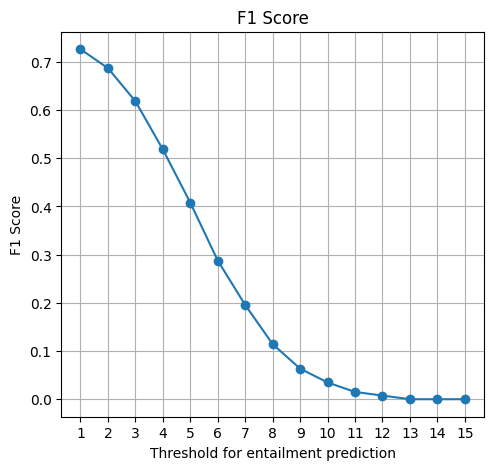

In [98]:
plt.figure(figsize=(12, 5))

# Plot for 'Bias_f1'
plt.subplot(1, 2, 1)
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.xlabel('Threshold for entailment prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.xticks(range(1, len(f1_scores) + 1))  
plt.grid()